## Notebook setup

In [1]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import dhelp

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd
import dhelp 
from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [2]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [3]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
#symbol = sys.argv[1]
symbol = "CMRE"

investor_report_url_dict= dhelp.get_investor_report_url_dict()
morningstar_report_url_dict=dhelp.get_morningstar_report_url_dict()
exchange_dict=dhelp.get_exchange_dict()
similar_companies_dict=dhelp.get_similar_companies_dict()

if (symbol in investor_report_url_dict):
    investor_report_url = investor_report_url_dict[symbol]
else:
    investor_report_url=""

if (symbol in morningstar_report_url_dict):
    morningstar_report_url = morningstar_report_url_dict[symbol]
else:
    morningstar_report_url= ""

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]

if (symbol in exchange_dict):
    exchange=exchange_dict[symbol]
else:
    exchange = "NYSE"

report_name = f"{symbol}".upper()

In [4]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [5]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for CMRE with starting period 2021-08-17.

('Investment Research Report on CMRE',
 '07 February, 2023',
 '22:58',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [6]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/23,ending 12/31/24
No. of Analysts,2,2,2,3,2
Average Estimate,259 USD,234 USD,257 USD,"1,052 USD","1,017 USD"
Year Ago,269 USD,271 USD,293 USD,-,"1,052 USD"
Publish Date,2/8/2023,5/3/2023,7/26/2023,-,-


In [7]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)
df_year_estimates

,2023,2024,2025
YEARLY ESTIMATES,,,
Revenue,"1,052","1,017",-
Dividend,0.46,0.46,-
Dividend Yield (in %),4.48 %,4.48 %,-
EPS,3.25,3.48,3.77
P/E Ratio,3.16,2.96,2.73


In [8]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

1 news articles for  Costamare Inc. were found since 2023-01-31

In [9]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Dimensional Fund Advisors LP,7.211 M,2022-09-29,5.93 %,75.139 M
2,Blackrock Inc.,2.632 M,2022-09-29,2.17 %,27.428 M
3,"Renaissance Technologies, LLC",2.559 M,2022-09-29,2.10 %,26.663 M
4,Morgan Stanley,1.881 M,2022-09-29,1.55 %,19.596 M
5,Goldman Sachs Group Inc,1.303 M,2022-09-29,1.07 %,13.580 M
6,"Bridgeway Capital Management, Inc.",999.600 K,2022-09-29,0.82 %,10.416 M
7,State Street Corporation,884.772 K,2022-09-29,0.73 %,9.219 M
8,"Ameriprise Financial, Inc.",826.889 K,2022-09-29,0.68 %,8.616 M
9,"Susquehanna International Group, LLP",810.907 K,2022-09-29,0.67 %,8.450 M
10,"American Century Companies, Inc.",486.222 K,2022-09-29,0.40 %,5.066 M


In [10]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,Dimensional Fund Advisors LP,7.211 M,2022-09-29,5.93 %,75.139 M
1,Blackrock Inc.,2.632 M,2022-09-29,2.17 %,27.428 M
2,"Renaissance Technologies, LLC",2.559 M,2022-09-29,2.10 %,26.663 M
3,Morgan Stanley,1.881 M,2022-09-29,1.55 %,19.596 M
4,Goldman Sachs Group Inc,1.303 M,2022-09-29,1.07 %,13.580 M
5,"Bridgeway Capital Management, Inc.",999.600 K,2022-09-29,0.82 %,10.416 M
6,State Street Corporation,884.772 K,2022-09-29,0.73 %,9.219 M
7,"Ameriprise Financial, Inc.",826.889 K,2022-09-29,0.68 %,8.616 M
8,"Susquehanna International Group, LLP",810.907 K,2022-09-29,0.67 %,8.450 M
9,"American Century Companies, Inc.",486.222 K,2022-09-29,0.40 %,5.066 M


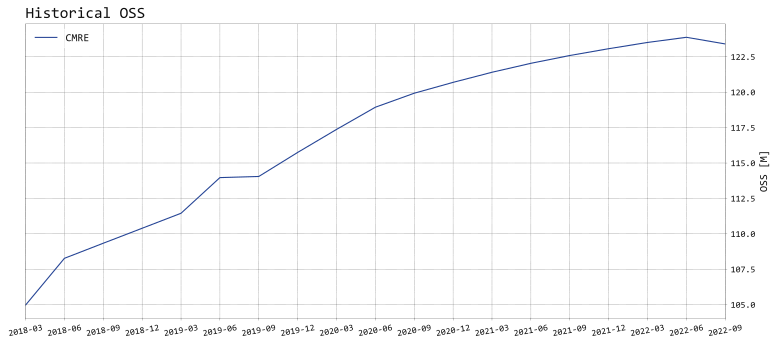

In [11]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric([symbol],"OSS", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
shares_outstanding_chart = f.getvalue().decode("utf-8")

In [12]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Dimensional Fund Advisors LP,7.211 M,2022-09-29,5.93 %,75.139 M
2,Blackrock Inc.,2.632 M,2022-09-29,2.17 %,27.428 M
3,"Renaissance Technologies, LLC",2.559 M,2022-09-29,2.10 %,26.663 M
4,Morgan Stanley,1.881 M,2022-09-29,1.55 %,19.596 M
5,Goldman Sachs Group Inc,1.303 M,2022-09-29,1.07 %,13.580 M
6,"Bridgeway Capital Management, Inc.",999.600 K,2022-09-29,0.82 %,10.416 M
7,State Street Corporation,884.772 K,2022-09-29,0.73 %,9.219 M
8,"Ameriprise Financial, Inc.",826.889 K,2022-09-29,0.68 %,8.616 M
9,"Susquehanna International Group, LLP",810.907 K,2022-09-29,0.67 %,8.450 M
10,"American Century Companies, Inc.",486.222 K,2022-09-29,0.40 %,5.066 M


In [13]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)
if (len(df_sec_filings) > 0):
    df_sec_filings = df_sec_filings[["Type", "Category", "Link"]].head(
        5
    )
    df_sec_filings["Link"] = df_sec_filings["Link"].apply(
        lambda x: f'<a href="{x}">{x}</a>'
    )
df_sec_filings

,Type,Category,Link
Filing Date,,,
01/05/2023,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16301335"">https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16301335</a>"
01/05/2023,SC 13G/A,Institutional Ownership,"<a href=""https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16301302"">https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16301302</a>"
10/13/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16133829"">https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16133829</a>"
08/11/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16010889"">https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=16010889</a>"
06/09/2022,SC 13D/A,N/A,"<a href=""https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=15883441"">https://www.marketwatch.com/investing/stock/cmre/financials/secfilings?docid=15883441</a>"


In [14]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

In [15]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-02-06,Buy,Strong Buy,Neutral,Neutral,Buy,Buy,Buy
2023-02-03,Buy,Strong Buy,Neutral,Neutral,Buy,Buy,Buy
2023-02-02,Buy,Strong Buy,Neutral,Neutral,Buy,Buy,Buy
2023-02-01,Buy,Strong Buy,Neutral,Neutral,Buy,Buy,Buy
2023-01-31,Buy,Strong Buy,Neutral,Neutral,Buy,Buy,Buy
...,...,...,...,...,...,...,...
2021-01-11,Neutral,Strong Buy,Neutral,Neutral,Buy,Strong Sell,Neutral
2021-01-08,Neutral,Strong Buy,Neutral,Neutral,Buy,Strong Sell,Neutral
2021-01-07,Neutral,Strong Buy,Neutral,Neutral,Buy,Strong Sell,Neutral


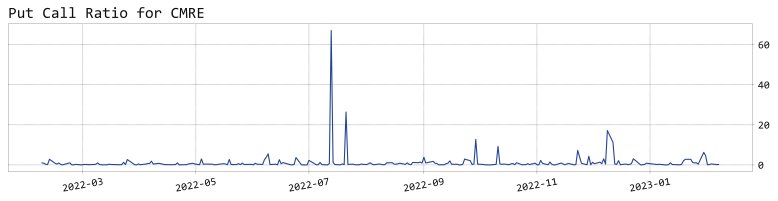

In [16]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [17]:
expiry_dates = openbb.stocks.options.expirations(symbol)
if (len(expiry_dates) > 0):
    exp = expiry_dates[0]
    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
else:
    option_chain = pd.DataFrame()


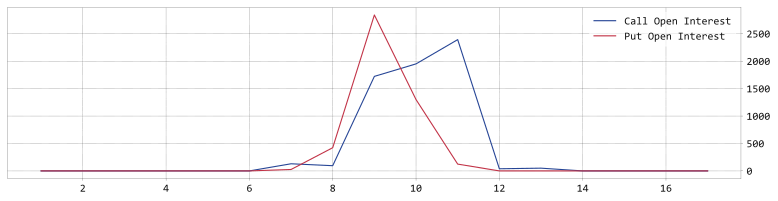

In [18]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    ax.plot(
        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
    )
    ax.plot(
        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
    )
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    vol_chart = f.getvalue().decode("utf-8")

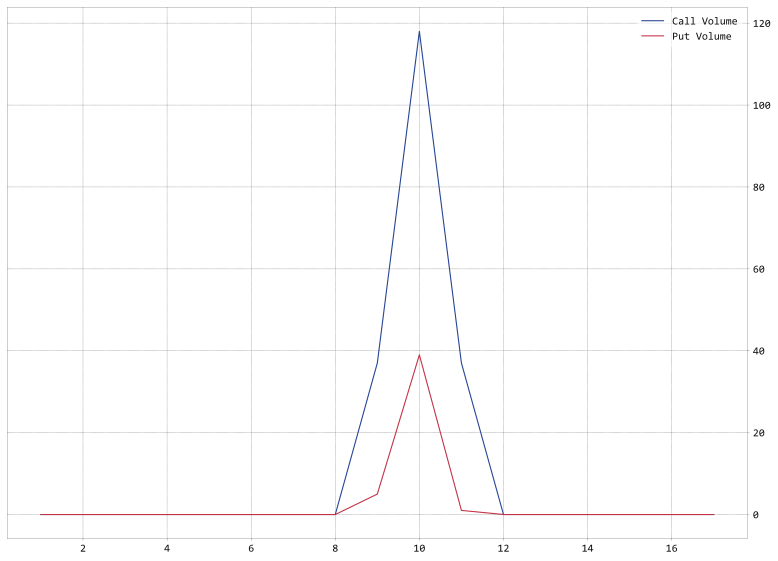

In [19]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    voi_chart = f.getvalue().decode("utf-8")

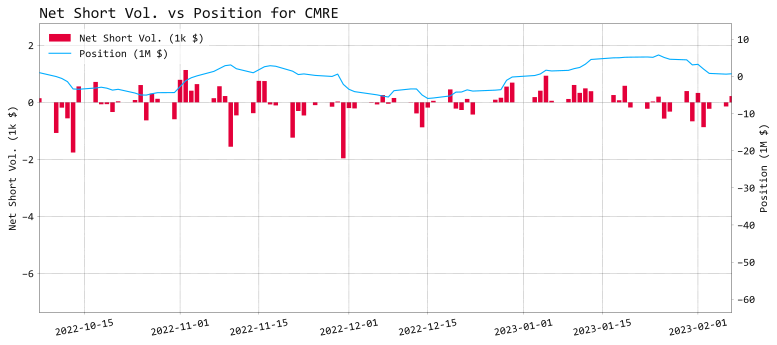

In [20]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

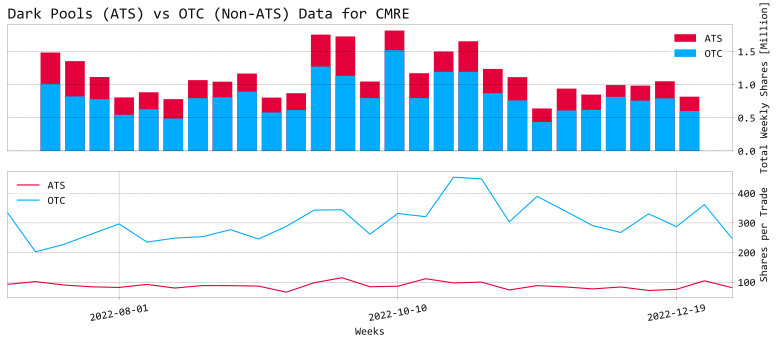

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

No congress trading data found

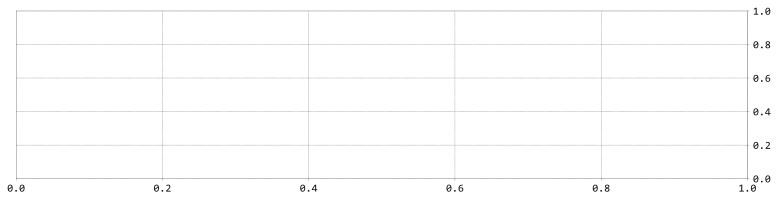

In [22]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

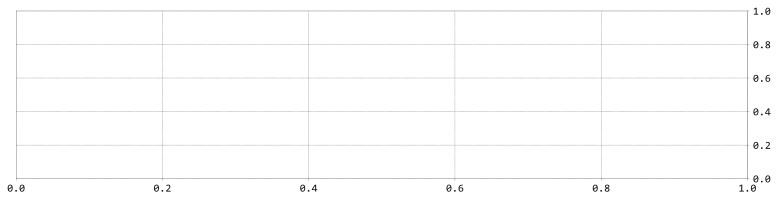

In [23]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

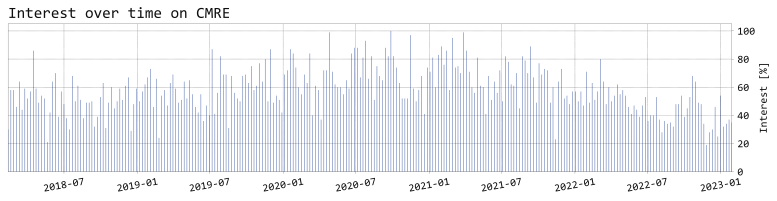

In [24]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

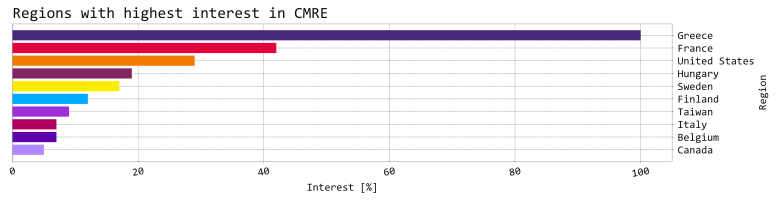

In [25]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")

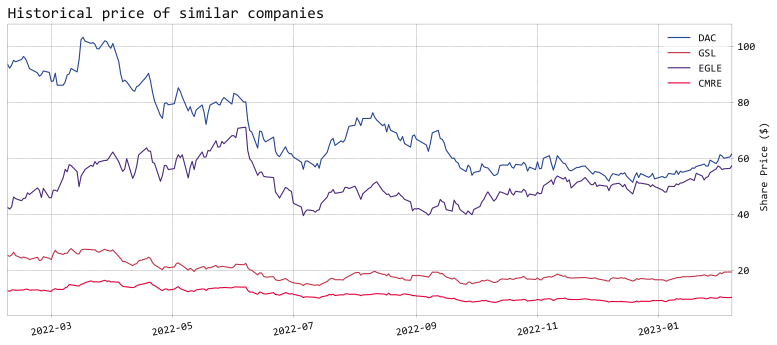

In [26]:

                    
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

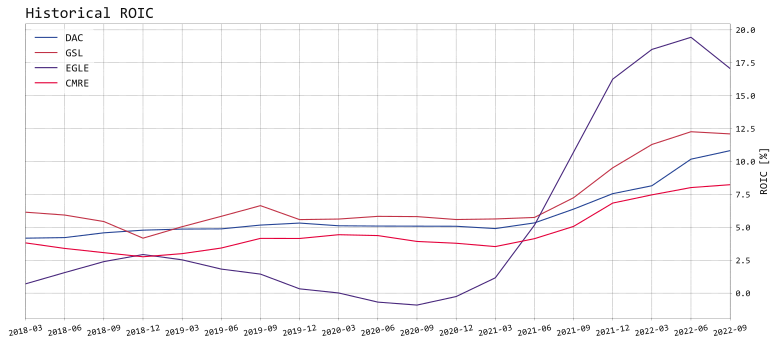

In [27]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"ROIC", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
roic_chart = f.getvalue().decode("utf-8")

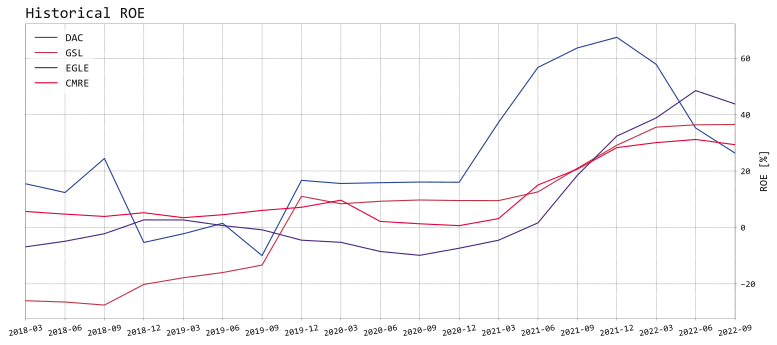

In [28]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"ROE", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
roe_chart = f.getvalue().decode("utf-8")

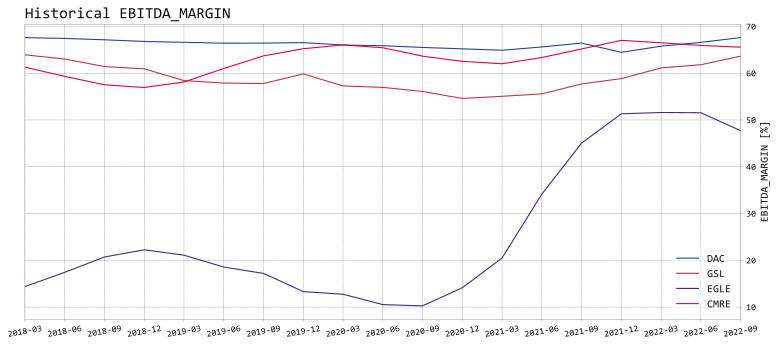

In [29]:
fig, ax = plt.subplots(figsize=(11,5), dpi=150)
dhelp.display_historical_metric(similar_companies,"EBITDA_MARGIN", external_axes=[
        ax,
    ])

fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ebitda_margin_chart = f.getvalue().decode("utf-8")

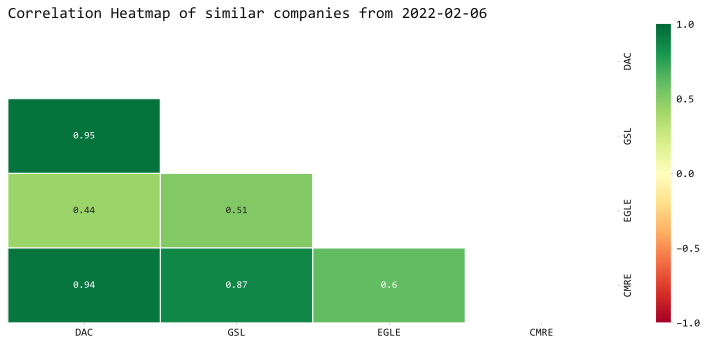

In [30]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

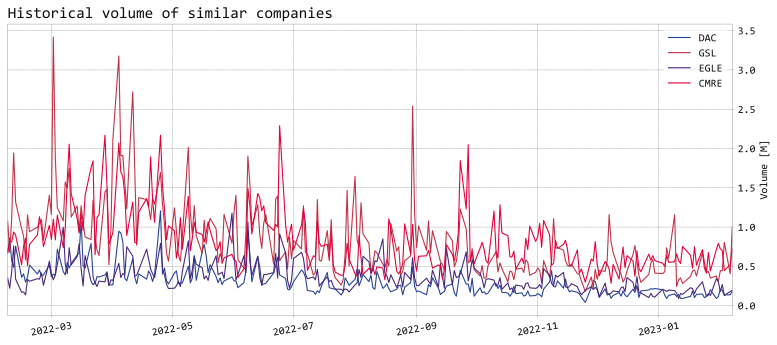

In [31]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

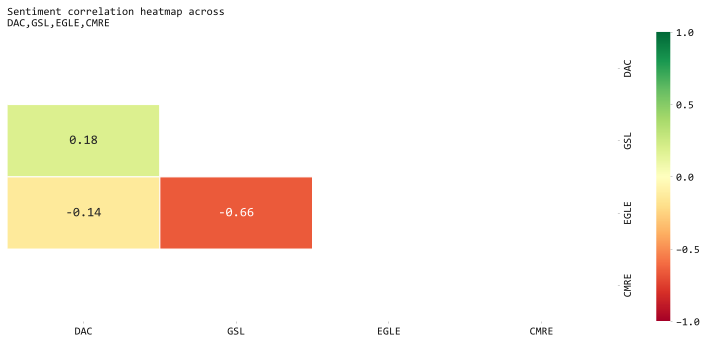

In [32]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [33]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])
valuation_comparison['Market Cap']=valuation_comparison['Market Cap'].apply(lambda x: "${0:.0f} M".format(x/1000000))

valuation_comparison = valuation_comparison.style.format({"EPS this Y": "${:,.2f}", "EPS next Y": "${:,.2f}", "EPS past 5Y": "${:,.2f}", 
                                                          "P/E": "{:,.2f}", "Fwd P/E":"{:,.2f}", "P/S": "{:,.2f}" , "P/B": "{:,.2f}" , 
                                                          "P/C":"{:,.2f}", "P/FCF": "{:,.2f}"} 
                                                        )
                                                      
#valuation_comparison['EPS this Y']=valuation_comparison['EPS this Y'].apply(lambda x: "${:,.2f}".format(x))

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,CMRE,$1320 M,2.62,3.03,1.17,0.64,2.05,13.30,$0.47,$-0.01,$0.33
1,DAC,$1260 M,2.22,2.41,1.32,0.52,nan,1.87,$6.93,$-0.26,$0.25
2,EGLE,$781 M,3.01,8.72,1.04,0.91,4.00,3.14,$4.47,$-0.63,$0.17
3,GSL,$695 M,2.60,2.24,1.10,0.78,5.79,2.69,$1.17,$0.09,$0.20


In [34]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
financial_comparison['Dividend']=financial_comparison['Dividend'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROA']=financial_comparison['ROA'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROE']=financial_comparison['ROE'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROI']=financial_comparison['ROI'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Gross M']=financial_comparison['Gross M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Oper M']=financial_comparison['Oper M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Profit M']=financial_comparison['Profit M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison= financial_comparison.fillna("")
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,CMRE,4.4%,10.6%,26.4%,10.3%,2.0,1.9,1.17,1.35,72.2%,55.4%,43.3%
1,DAC,4.9%,15.3%,24.6%,13.6%,2.3,2.3,0.34,0.38,80.1%,62.9%,59.9%
2,EGLE,12.6%,26.2%,42.3%,24.3%,2.1,1.9,0.36,0.42,65.1%,41.2%,41.5%
3,GSL,7.7%,13.6%,34.5%,13.3%,0.8,0.8,0.86,1.07,70.8%,56.0%,44.3%


In [35]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])
ownership_comparison= ownership_comparison.fillna("")
ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,CMRE,121430000.0,51940000.0,0.779,0.0000,0.226,-0.0426,0.0387,3.45
1,DAC,20300000.0,10820000.0,0.587,0.0000,0.214,-0.1932,0.0569,3.53
2,EGLE,12990000.0,12740000.0,0.016,-0.0644,0.864,-0.0682,0.1182,7.04
3,GSL,36650000.0,34050000.0,0.790,0.0000,0.476,-0.1075,0.0896,6.11


In [36]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])
performance_comparison['Perf Week']=performance_comparison['Perf Week'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Month']=performance_comparison['Perf Month'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Quart']=performance_comparison['Perf Quart'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Half']=performance_comparison['Perf Half'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Year']=performance_comparison['Perf Year'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf YTD']=performance_comparison['Perf YTD'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison= performance_comparison.fillna("")
performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,CMRE,2.7%,10.5%,6.0%,-10.2%,-18.1%,12.3%,0.0340,0.0328,1.7
1,DAC,4.1%,12.8%,1.3%,-18.9%,-35.2%,17.0%,0.0349,0.0314,1.7
2,EGLE,0.2%,14.8%,10.7%,8.2%,21.5%,14.9%,0.0256,0.0340,1.5
3,GSL,4.8%,17.6%,9.5%,-1.1%,-24.6%,16.6%,0.0415,0.0305,1.5


In [37]:
df_historical_metrics = openbb.stocks.fa.metrics(symbol)
df_historical_metrics

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Revenue per share,6.449,3.814,4.131,3.446,4.103
Net income per share,3.536,0.074,0.855,0.609,0.725
Operating cash flow per share,3.790,2.273,2.163,1.275,1.900
Free cash flow per share,-4.271,1.428,1.628,-0.020,1.261
Cash per share,2.243,1.192,1.287,1.030,1.780
Book value per share,14.024,11.175,12.188,12.293,12.121
Tangible book value per share,14.018,11.168,12.179,12.282,12.121
Shareholders equity per share,14.024,11.175,12.188,12.293,12.121
Interest debt per share,21.372,13.657,14.166,15.475,12.724


In [38]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [39]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

No quarterly government contracts found

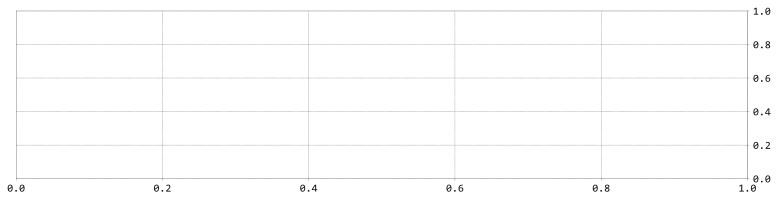

In [40]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [41]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

No corporate lobbying found

""


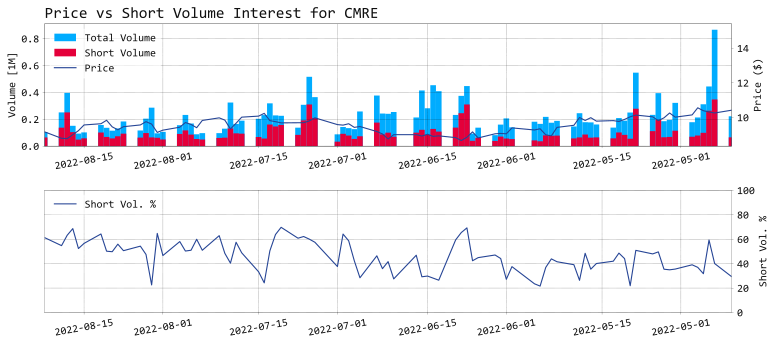

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

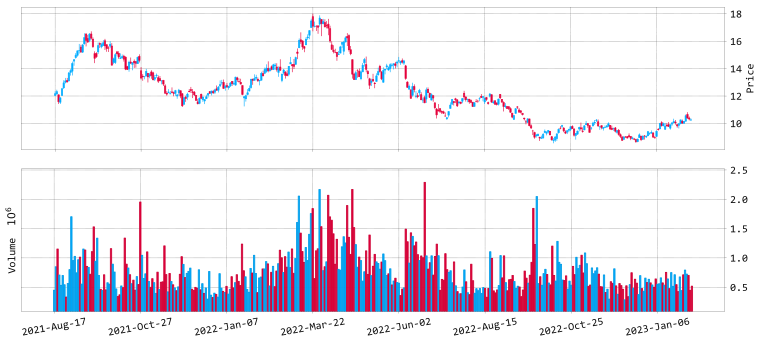

In [43]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

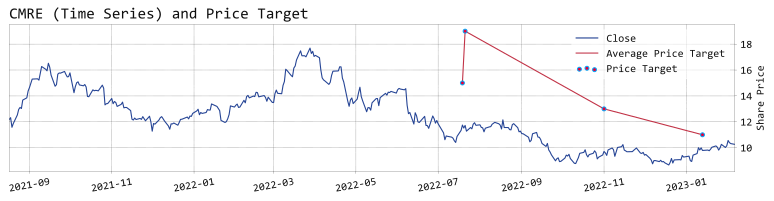

In [44]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [45]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

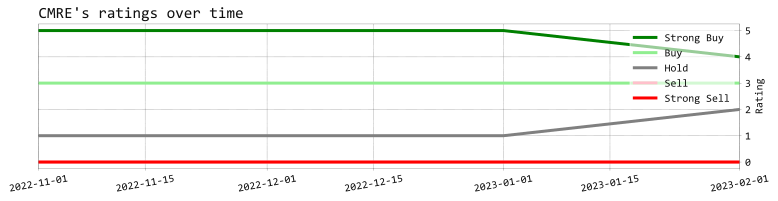

In [46]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

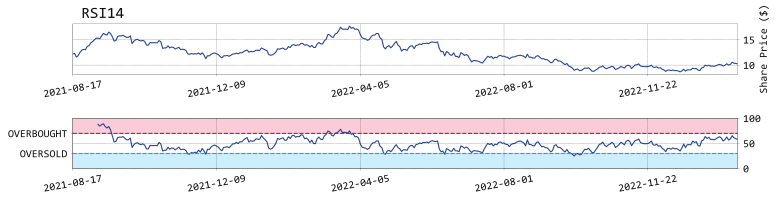

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [48]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

57.98

In [49]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [50]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

No insider information found for CMRE.

empty


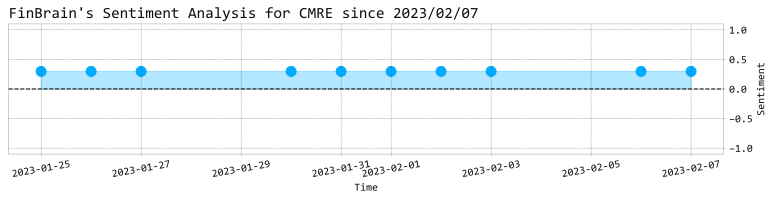

In [51]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [52]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [53]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 1301</br>\nLast 2 sentiment messages:</br>Bullish 50.0%</br>Bearish 50.0%'

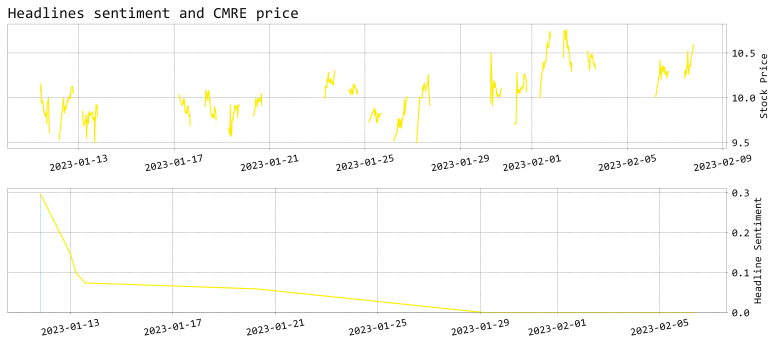

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [55]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for CMRE with starting period 2019-08-28.

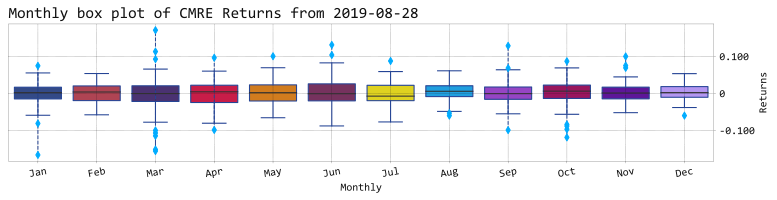

In [56]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

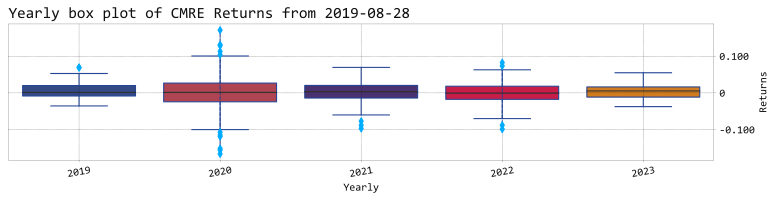

In [57]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [58]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for CMRE

empty


Ticker should be a NASDAQ 100 ticker or SP 500 ticker

In [59]:
hist_ratios = openbb.stocks.fa.ratios(symbol)
hist_ratios

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Current ratio,1.152,0.928,0.740,0.760,0.819
Quick ratio,0.833,0.747,0.621,0.581,0.679
Cash ratio,0.746,0.695,0.559,0.506,0.647
Days of sales outstanding,14.859,8.528,12.658,16.103,7.853
Days of inventory outstanding,22.168,15.344,15.454,17.388,15.883
Operating cycle,37.028,23.872,28.111,33.491,23.735
Days of payables outstanding,19.574,11.128,9.107,13.548,10.379
Cash conversion cycle,17.453,12.744,19.004,19.943,13.356
Gross profit margin,0.557,0.460,0.479,0.392,0.462


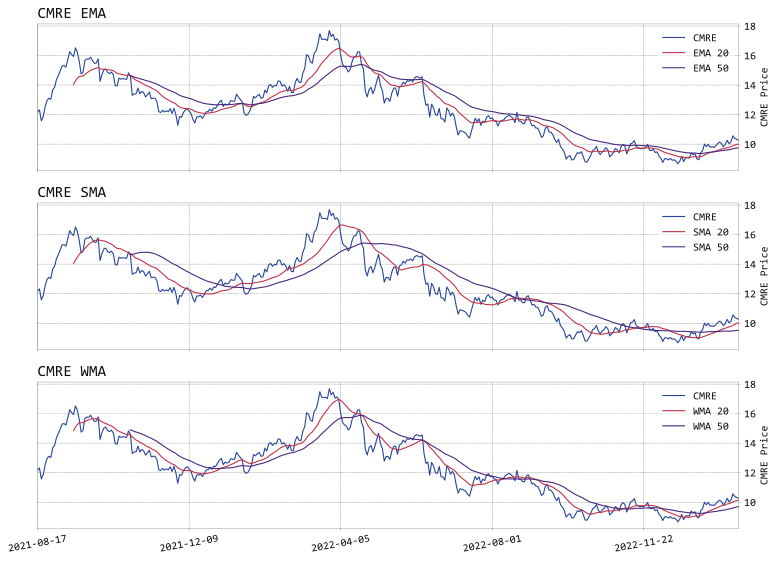

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

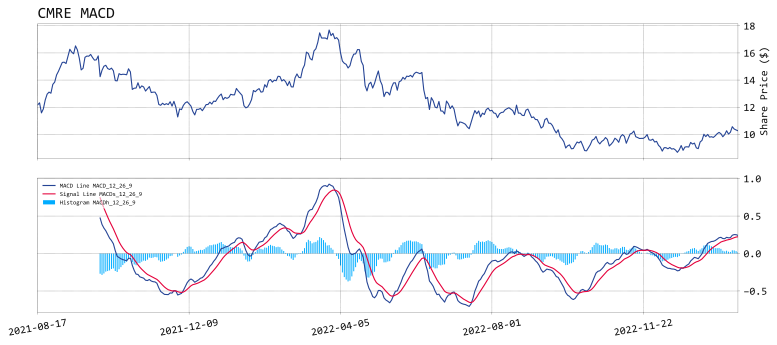

In [61]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

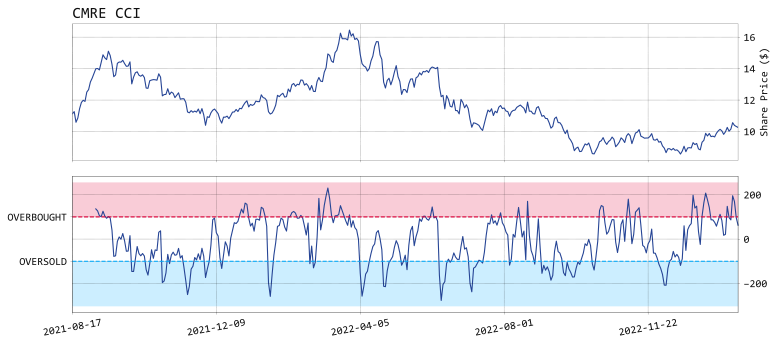

In [62]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

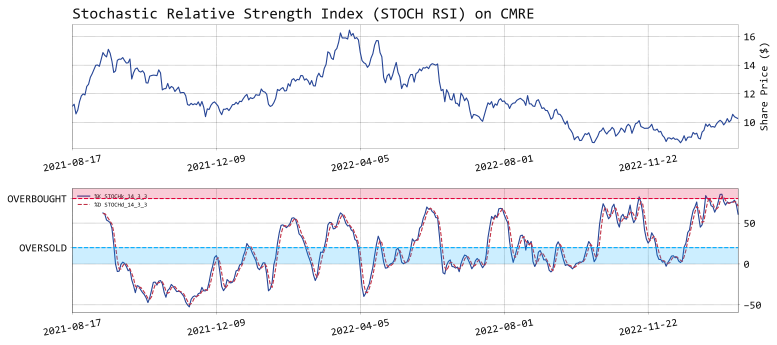

In [63]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

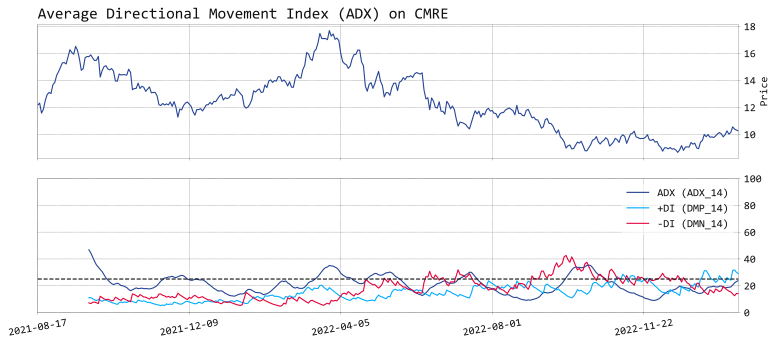

In [64]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

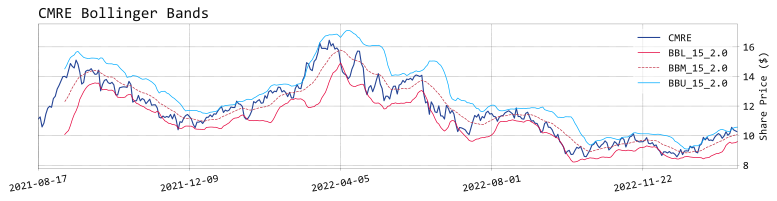

In [65]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

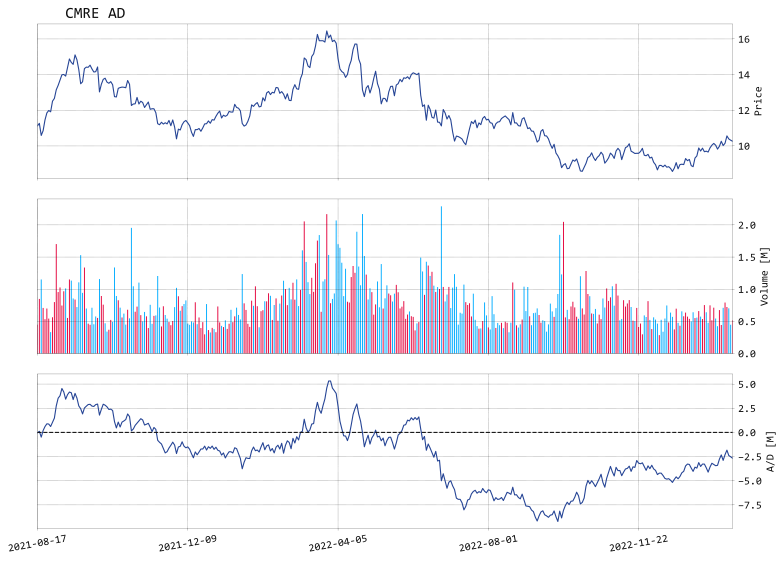

In [66]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [67]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
                {{
                "width": "1085",
                "height": "500",
                "colorTheme": "light",
                "isTransparent": false,
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

if (investor_report_url): 
    htmlcode += widgets.row([widgets.h(3, "Investor Presentation for " + symbol)])
    htmlcode += f"""
        <div class="hcontainer">
            <div class="item">
                <iframe src="{investor_report_url}" width="1085" height="700"></iframe>
            </div>
        </div>
            """

            
body += widgets.add_tab("Summary", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
        <div class="tradingview-widget-container">
        <div id="tradingview_fceac"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
        <script type="text/javascript">
        new TradingView.MediumWidget(
            {{
            "symbols": [
                [
                "{long_name}",
                "{exchange}:{symbol}|1D"
                ]
            ],
            "chartOnly": false,
            "width": "1085",
            "height": "700",
            "locale": "en",
            "colorTheme": "light",
            "autosize": false,
            "showVolume": false,
            "hideDateRanges": false,
            "hideMarketStatus": false,
            "scalePosition": "right",
            "scaleMode": "Normal",
            "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
            "fontSize": "10",
            "noTimeScale": false,
            "valuesTracking": "1",
            "chartType": "line",
            "container_id": "tradingview_fceac"
            }}
        );
        </script>
        </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
<div class="hcontainer">
    <div class="item">
        <div class="tweet-list">
            {% for tweet in tweets %}
            <div class="tweet">
                <div class="tweet-header">
                    <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                    <h3>{{ tweet.user.name }}</h3>                   
                </div>       
                <div class="tweet-body">
                    <p>{{ tweet.full_text }}</p>
                </div>   
                {% if tweet.entities.media %}
                    <div class="tweet-media">
                    {% for media in tweet.entities.media %}
                        <img src="{{ media.media_url_https }}" alt="Tweet media">
                    {% endfor %}
                    </div>
                {% endif %}
                <div class="tweet-footer">
                    {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                    <p>{{ date }}</p>
                    <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
                </div>
            </div>
            {% endfor %}
        </div>
    </div>
</div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

if(morningstar_report_url):
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis " + symbol)])
    htmlcode += f"""
            <div class="hcontainer">
                <div class="item">
                <iframe src="{morningstar_report_url}" width="1085" height="700" allow="autoplay"></iframe>
                </div>
            </div>
                """
else:
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis not available ")])

htmlcode += widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.head(15).to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
                {{
                "colorTheme": "light",
                "isTransparent": false,
                "largeChartUrl": "",
                "displayMode": "regular",
                "width": "1085",
                "height": "800",
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Shares outstanding ") + shares_outstanding_chart]
    )
except:
    pass

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Ratios") + hist_ratios.to_html(escape=False)])

htmlcode += widgets.row([widgets.h(3, "Metrics") + df_historical_metrics.to_html(escape=False)])

body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
if not option_chain.empty:
    htmlcode += widgets.row(
        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
    )
    htmlcode += widgets.row(
        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
    )
try:
    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
except:
    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

htmlcode = widgets.row(
    [
        widgets.h(3, f"Return on invested capital for companies similar to {symbol}")
        + roic_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Return on equity for companies similar to {symbol}")
        + roe_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"EBITDA margin for companies similar to {symbol}")
        + ebitda_margin_chart
    ]
)

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)

try:
    htmlcode += widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
                {{
                "interval": "1W",
                "width": "1085",
                "isTransparent": false,
                "height": "700",
                "symbol": "{exchange}:{symbol}",
                "showIntervalTabs": true,
                "locale": "en",
                "colorTheme": "light"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)

NameError: name 'pb_chart' is not defined